# CNF vs RealNVP

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
mlflow.set_experiment('cnf_trace_computation')
from itertools import product
import torch
from datetime import datetime, timezone
import numpy as np
import json

from even_flow.moons.jobs import (
    MoonsTimeEmbeddingMLPCNFJob,
    MoonsRealNVPJob
)
from even_flow.moons.dataset import MoonsDataset
from even_flow.models.cnf import TimeEmbeddingMLPCNFModel
from even_flow.models.real_nvp import RealNVPModel
from even_flow.utils import set_logger

logger = set_logger()

/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'default' attribute with value None was provided to the `Field()` function, which has no effect in the context it was used. 'default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


# Dual Moons

In [2]:
train_samples = 10000
val_samples = 1000
test_samples = 1000
noise = 0.05
batch_size = 32
random_state = 943874

datamodule = MoonsDataset(
    train_samples=train_samples,
    val_samples=val_samples,
    test_samples=test_samples,
    noise=noise,
    batch_size=batch_size,
    random_state=random_state
)

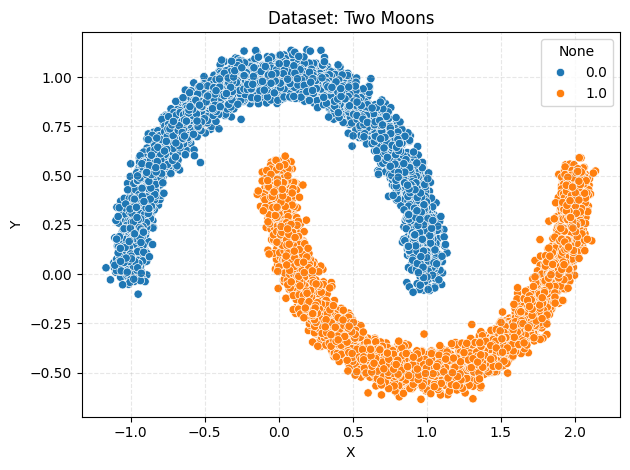

In [3]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.scatterplot(
    x=datamodule.train_X[:, 0].reshape(-1),
    y=datamodule.train_X[:, 1].reshape(-1),
    hue=datamodule.train_y.reshape(-1),
    ax=ax
)
ax.set(
    title='Dataset: Two Moons',
    xlabel='X',
    ylabel='Y'
)
fig.tight_layout()
moons_xlim = ax.get_xlim()
moons_ylim = ax.get_ylim()

## RealNVP

In [4]:
experiment_name = 'Moons Real NVP'
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/mlruns/425052754478199524', creation_time=1764488699917, experiment_id='425052754478199524', last_update_time=1764488699917, lifecycle_stage='active', name='Moons Real NVP', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [5]:
neuron_options = [
    [64, 64],
    [64, 64, 64, 64],
    [256, 256]
]
activation_options = ['gelu', 'tanh']
real_nvp_jobs = []
for i, (neurons, activation) in enumerate(product(neuron_options, activation_options)):
    logger.info(
        f'Running job: real-nvp-moons-{i} | Hidden features: {neurons} | Activation: {activation}')
    job = MoonsRealNVPJob(
        name=f'real-nvp-moons-{i}',
        datamodule=datamodule,
        model=RealNVPModel(
            features=2,
            transforms=4,
            hidden_features=neurons,
            checkpoint=dict(
                monitor='val_loss',
                mode='min',
            ),
            early_stopping=dict(
                monitor='val_loss',
                mode='min',
                patience=5,
                min_delta=1e-3
            ),
            learning_rate=1e-3,
            max_epochs=50,
            activation=activation
        )
    )
    job.run()
    real_nvp_jobs.append(job)

2025-11-30 13:53:53 | INFO | root | 2439316933 | 9 | Running job: real-nvp-moons-0 | Hidden features: [64, 64] | Activation: gelu
2025-11-30 13:53:53 | INFO | even_flow | jobs | 66 | Fitting model...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | RealNVP          | 17.7 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 313/313 [00:04<00:00, 75.75it/s, v_num=7fe8, train_loss_step=0.449, val_loss=0.425, train_loss_epoch=0.455] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 313/313 [00:04<00:00, 75.47it/s, v_num=7fe8, train_loss_step=0.449, val_loss=0.425, train_loss_epoch=0.455]


2025/11/30 13:57:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 13:57:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 13:57:18 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/core/module.py:449: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


2025-11-30 13:57:19 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 13:57:19 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 13:57:19 | INFO | root | 2439316933 | 9 | Running job: real-nvp-moons-1 | Hidden features: [64, 64] | Activation: tanh
2025-11-30 13:57:19 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 13:57:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 13:57:19 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | RealNVP          | 17.7 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 31: 100%|██████████| 313/313 [00:03<00:00, 88.21it/s, v_num=1d4f, train_loss_step=0.466, val_loss=0.479, train_loss_epoch=0.501] 


2025/11/30 13:59:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 13:59:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 13:59:22 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 13:59:22 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 13:59:22 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 13:59:22 | INFO | root | 2439316933 | 9 | Running job: real-nvp-moons-2 | Hidden features: [64, 64, 64, 64] | Activation: gelu
2025-11-30 13:59:22 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 13:59:22 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 13:59:22 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | RealNVP          | 51.0 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Epoch 21: 100%|██████████| 313/313 [00:05<00:00, 60.53it/s, v_num=48c4, train_loss_step=0.198, val_loss=0.443, train_loss_epoch=0.434]


2025/11/30 14:01:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 14:01:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 14:01:19 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 14:01:20 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 14:01:21 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 14:01:21 | INFO | root | 2439316933 | 9 | Running job: real-nvp-moons-3 | Hidden features: [64, 64, 64, 64] | Activation: tanh
2025-11-30 14:01:21 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 14:01:21 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 14:01:21 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | RealNVP          | 51.0 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Epoch 47: 100%|██████████| 313/313 [00:04<00:00, 69.92it/s, v_num=c3d8, train_loss_step=0.430, val_loss=0.443, train_loss_epoch=0.487]


2025/11/30 14:05:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 14:05:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 14:05:10 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 14:05:10 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 14:05:10 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 14:05:10 | INFO | root | 2439316933 | 9 | Running job: real-nvp-moons-4 | Hidden features: [256, 256] | Activation: gelu
2025-11-30 14:05:10 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 14:05:10 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 14:05:10 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | RealNVP          | 267 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
267 K     Trainable params
0         Non-trainable params
267 K     Total params
1.069     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


Epoch 31: 100%|██████████| 313/313 [00:04<00:00, 67.98it/s, v_num=ce07, train_loss_step=0.374, val_loss=0.441, train_loss_epoch=0.507]


2025/11/30 14:07:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 14:07:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 14:07:43 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 14:07:44 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 14:07:44 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-11-30 14:07:44 | INFO | root | 2439316933 | 9 | Running job: real-nvp-moons-5 | Hidden features: [256, 256] | Activation: tanh
2025-11-30 14:07:44 | INFO | even_flow | jobs | 66 | Fitting model...
2025-11-30 14:07:44 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-11-30 14:07:44 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | RealNVP          | 267 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
267 K     Trainable params
0         Non-trainable params
267 K     Total params
1.069     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


Epoch 16: 100%|██████████| 313/313 [00:04<00:00, 68.41it/s, v_num=239f, train_loss_step=0.582, val_loss=0.601, train_loss_epoch=0.743] 


2025/11/30 14:09:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/30 14:09:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-11-30 14:09:02 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-11-30 14:09:02 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-11-30 14:09:02 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset


In [6]:
experiment = mlflow.get_experiment_by_name(experiment_name)
real_nvp_runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
real_nvp_runs_df = real_nvp_runs_df[real_nvp_runs_df['status'] == 'FINISHED']
real_nvp_runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test.eval_start,metrics.exec_duration,metrics.train.eval_end,metrics.val.eval_start,...,params.model.num_sanity_val_steps,params.model.verbose,params.model.early_stopping..monitor,params.model.learning_rate,params.datamodule.test_samples,params.datamodule.train_samples,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.type
0,41641689d698461eba1a86cae551239f,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 17:07:44.600000+00:00,2025-11-30 17:09:02.947000+00:00,1.764523e+09,78.336701,1.764523e+09,1.764523e+09,...,5,True,val_loss,0.001,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,real-nvp-moons-5,LOCAL
1,ea50550941f84e9ab5263bd2a500ce07,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 17:05:10.858000+00:00,2025-11-30 17:07:44.594000+00:00,1.764522e+09,153.724301,1.764522e+09,1.764522e+09,...,5,True,val_loss,0.001,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,real-nvp-moons-4,LOCAL
2,26b7452e4d494fb9a0cc14341281c3d8,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 17:01:21.080000+00:00,2025-11-30 17:05:10.853000+00:00,1.764522e+09,229.757353,1.764522e+09,1.764522e+09,...,5,True,val_loss,0.001,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,real-nvp-moons-3,LOCAL
3,b95c5fd3d6cc4610a4214d59babd48c4,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 16:59:22.888000+00:00,2025-11-30 17:01:21.075000+00:00,1.764522e+09,118.176244,1.764522e+09,1.764522e+09,...,5,True,val_loss,0.001,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,real-nvp-moons-2,LOCAL
4,cd2d83425ca74f34a9f1e21d06bd1d4f,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 16:57:19.404000+00:00,2025-11-30 16:59:22.879000+00:00,1.764522e+09,123.462622,1.764522e+09,1.764522e+09,...,5,True,val_loss,0.001,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,real-nvp-moons-1,LOCAL
5,9d014a7f77ff4a4695e3f3f3bc957fe8,425052754478199524,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 16:53:53.322000+00:00,2025-11-30 16:57:19.399000+00:00,1.764522e+09,206.067707,1.764522e+09,1.764522e+09,...,5,True,val_loss,0.001,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,real-nvp-moons-0,LOCAL


In [7]:
for i, col in enumerate(real_nvp_runs_df.columns):
    print(f'{i} - {col}')

0 - run_id
1 - experiment_id
2 - status
3 - artifact_uri
4 - start_time
5 - end_time
6 - metrics.test.eval_start
7 - metrics.exec_duration
8 - metrics.train.eval_end
9 - metrics.val.eval_start
10 - metrics.epoch
11 - metrics.train_loss_epoch
12 - metrics.exec_start
13 - metrics.test.loss
14 - metrics.val.eval_duration
15 - metrics.val_loss
16 - metrics.fit_end
17 - metrics.test.eval_end
18 - metrics.test.eval_duration
19 - metrics.fit_start
20 - metrics.val.loss
21 - metrics.exec_end
22 - metrics.val.eval_end
23 - metrics.fit_duration
24 - metrics.train_loss_step
25 - metrics.train.eval_start
26 - metrics.train.loss
27 - metrics.train.eval_duration
28 - params.model.checkpoint.mode
29 - params.model.checkpoint.monitor
30 - params.model.hidden_features
31 - params.model.max_epochs
32 - params.datamodule.random_state
33 - params.model.activation
34 - params.model.randmask
35 - params.model.transforms
36 - params.datamodule.val_samples
37 - params.model.features
38 - params.model.context


### Activation X Test Loss X Hidden Features

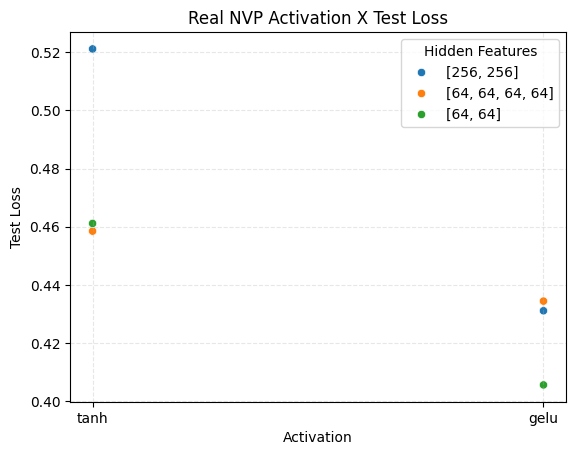

In [8]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.scatterplot(
    y='metrics.test.loss', 
    x='params.model.activation', 
    data=real_nvp_runs_df,
    hue='params.model.hidden_features',
    ax=ax
)
ax.set(
    xlabel='Activation',
    ylabel='Test Loss',
    title='Real NVP Activation X Test Loss'
)
ax.legend(title='Hidden Features')

### Fit duration

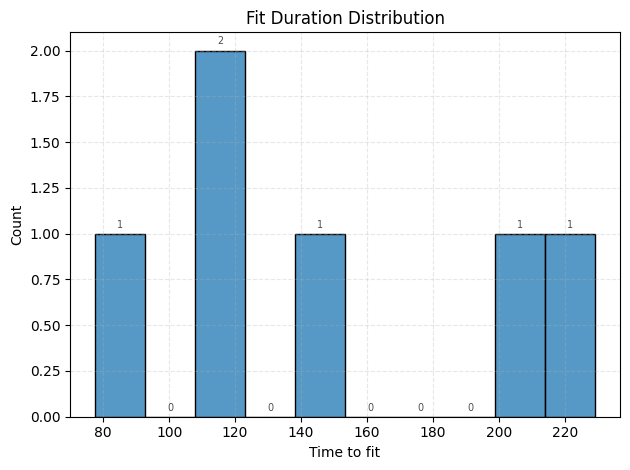

In [24]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    real_nvp_runs_df,
    x='metrics.fit_duration',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=10
)
plt.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=3,
              fontsize='x-small', alpha=0.7) 
ax.set_title(
    'Fit Duration Distribution',
    fontsize='large'
)
ax.set_xlabel('Time to fit', fontsize='medium')
fig.tight_layout()

### Min test loss

In [9]:
min_nvp_idx = real_nvp_runs_df['metrics.test.loss'].idxmin()
min_nvp_run = real_nvp_runs_df.loc[min_nvp_idx]
for job in real_nvp_jobs:
    if job.id_ == min_nvp_run['run_id']:
        min_nvp_job = job
        break
min_nvp_job

MoonsRealNVPJob(id_='9d014a7f77ff4a4695e3f3f3bc957fe8', name='real-nvp-moons-0', model=RealNVPModel(id_=None, name=None, prefix='', accelerator='cpu', profiler='simple', max_epochs=50, verbose=True, num_sanity_val_steps=5, checkpoint=ModelCheckpointConfig(id_=None, name=None, prefix='', dirpath=None, monitor='val_loss', mode='min', save_top_k=3, filename='checkpoint-{epoch:02d}-{val_loss:.2f}'), early_stopping=EarlyStoppingConfig(id_=None, name=None, prefix='', monitor='val_loss', patience=5, min_delta=0.001, mode='min'), features=2, context=0, transforms=4, randmask=False, learning_rate=0.001, hidden_features=[64, 64], activation='gelu'), datamodule=<even_flow.moons.dataset.MoonsDataset object at 0x7ef6597cfa70>, metrics={'train': {'loss': 0.41079458594322205}, 'val': {'loss': 0.4254758656024933}, 'test': {'loss': 0.4055539071559906}, 'predict': {}})

2025-12-01 01:35:18 | INFO | root | 2194290636 | 12 | Average sampling time over 100 runs: 0.00299 ± 0.00375 seconds


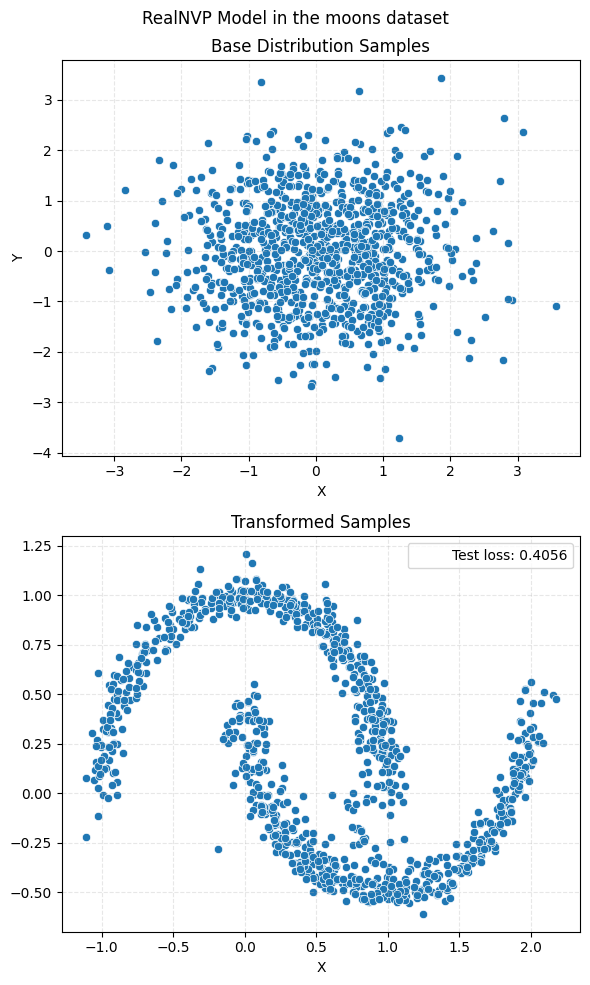

In [29]:
sample_time_estimation = 100
n_samples = 1000
delta = []
for _ in range(sample_time_estimation):
    start = datetime.now(timezone.utc).timestamp()
    min_nvp_job.model.sample((n_samples,))
    finish = datetime.now(timezone.utc).timestamp()
    delta.append(finish - start)
delta = np.array(delta)
avg = np.mean(delta)
std = np.std(delta)
logger.info(f'Average sampling time over {sample_time_estimation} runs: {avg:.5f} ± {std:.5f} seconds')

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
transformed_samples, base_samples, fig, axes = min_nvp_job.plot_comparison(n_samples=n_samples, axes=axes)
fig.suptitle('RealNVP Model in the moons dataset')
fig.tight_layout()
axes[1].plot([], [], ' ',
             label=f'Test loss: {min_nvp_run["metrics.test.loss"]:.4f}',)
axes[1].legend()

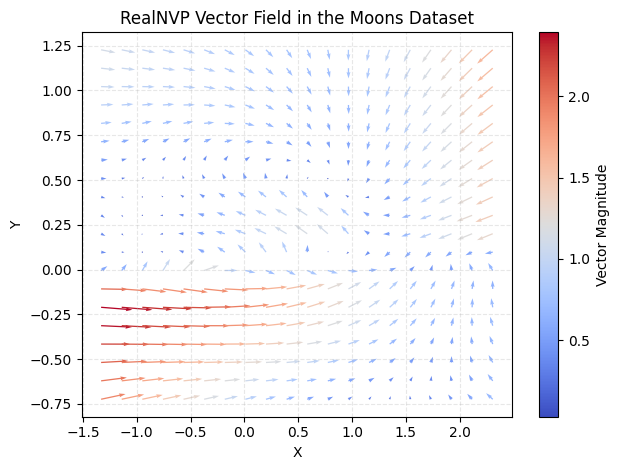

In [11]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
min_nvp_job.vector_field_plot(
    x=torch.linspace(moons_xlim[0], moons_xlim[1], 20),
    y=torch.linspace(moons_ylim[0], moons_ylim[1], 20),
    ax=ax,
    cmap='coolwarm'
)
ax.set(
    xlabel='X', ylabel='Y',
    title='RealNVP Vector Field in the Moons Dataset'
)
fig.tight_layout()

## Exact CNF

In [34]:
experiment_name = 'Moons Exact CNF 2'
mlflow.set_experiment(experiment_name)

2025/12/01 02:01:19 INFO mlflow.tracking.fluent: Experiment with name 'Moons Exact CNF 2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/mlruns/359766082964690979', creation_time=1764565280004, experiment_id='359766082964690979', last_update_time=1764565280004, lifecycle_stage='active', name='Moons Exact CNF 2', tags={}>

In [35]:
exact_cnf_jobs = []
for i, (activation, neurons_per_layer) in enumerate(product(activation_options, neuron_options)):
    logger.info(f'Running job: exact-cnf-moons-{i}')
    job = MoonsTimeEmbeddingMLPCNFJob(
        name=f'exact-cnf-moons-{i}',
        datamodule=datamodule,
        model=TimeEmbeddingMLPCNFModel(
            vector_field=dict(
                input_dims=2,
                time_embed_dims=16,
                time_embed_freq=100,
                neurons_per_layer=neurons_per_layer + [2],
                activations=(len(neurons_per_layer) + 1)*[activation],
            ),
            adjoint=True,
            base_distribution='standard_normal',
            max_epochs=5,
            patience=1,
            verbose=True,
            min_delta=1,
            input_shape=(2,),
            monitor='val_loss',
            mode='min',
            atol=1e-2,
            rtol=1e-2,
            solver='rk4'
        )
    )
    job.run()
    exact_cnf_jobs.append(job)

2025-12-01 02:01:21 | INFO | root | 110929913 | 3 | Running job: exact-cnf-moons-0
2025-12-01 02:01:21 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 02:01:22 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 02:01:22 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | vector_field  | TimeEmbeddingMLP | 5.5 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 313/313 [00:08<00:00, 36.62it/s, v_num=810d, train_loss_step=-1.21e+3, val_loss=-1.18e+3, train_loss_epoch=-304.]


2025/12/01 02:01:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/01 02:01:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025-12-01 02:01:33 | INFO | even_flow | jobs | 98 | Evaluating model on train dataset
2025-12-01 02:01:35 | INFO | even_flow | jobs | 98 | Evaluating model on val dataset
2025-12-01 02:01:36 | INFO | even_flow | jobs | 98 | Evaluating model on test dataset
2025-12-01 02:01:36 | INFO | root | 110929913 | 3 | Running job: exact-cnf-moons-1
2025-12-01 02:01:36 | INFO | even_flow | jobs | 66 | Fitting model...
2025-12-01 02:01:36 | INFO | pytorch_lightning.utilities.rank_zero | setup | 155 | GPU available: False, used: False
2025-12-01 02:01:36 | INFO | pytorch_lightning.utilities.rank_zero | setup | 158 | TPU available: False, using: 0 TPU cores



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | vector_field  | TimeEmbeddingMLP | 13.8 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Epoch 0:  56%|█████▌    | 175/313 [00:06<00:05, 26.56it/s, v_num=7eea, train_loss_step=-2.9e+4] 2025-12-01 02:01:43 | INFO | pytorch_lightning.utilities.rank_zero | call | 58 | 
Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
experiment = mlflow.get_experiment_by_name(experiment_name)
exact_cnf_runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
exact_cnf_runs_df = exact_cnf_runs_df[exact_cnf_runs_df['status'] == 'FINISHED']
exact_cnf_runs_df['params.model.vector_field.activations'] = exact_cnf_runs_df['params.model.vector_field.activations'].apply(
    lambda x: json.loads(x)[0]
)
exact_cnf_runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test.eval_start,metrics.exec_duration,metrics.train.eval_end,metrics.val.eval_start,...,params.model.verbose,params.model.learning_rate,params.model.mode,params.model.solver,params.datamodule.test_samples,params.datamodule.train_samples,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.type
0,0fe4b49a3e7e42d386a38349616bb07f,759513563270235963,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 17:17:12.309000+00:00,2025-11-30 17:18:22.898000+00:00,1.764523e+09,70.580079,1.764523e+09,1.764523e+09,...,True,0.001,min,dopri5,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,exact-cnf-moons-5,LOCAL
1,cdb6aecbf9ad4939a1f5f0bda0c1dfa8,759513563270235963,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 17:15:53.901000+00:00,2025-11-30 17:17:12.304000+00:00,1.764523e+09,78.397286,1.764523e+09,1.764523e+09,...,True,0.001,min,dopri5,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,exact-cnf-moons-4,LOCAL
2,78ef7222dae043e6a2df1f64c4922209,759513563270235963,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 17:15:06.955000+00:00,2025-11-30 17:15:53.896000+00:00,1.764523e+09,46.933826,1.764523e+09,1.764523e+09,...,True,0.001,min,dopri5,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,exact-cnf-moons-3,LOCAL
3,c1f6b0bc69d54906ada222f43f980d0d,759513563270235963,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 17:13:30.630000+00:00,2025-11-30 17:15:06.949000+00:00,1.764523e+09,96.311851,1.764523e+09,1.764523e+09,...,True,0.001,min,dopri5,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,exact-cnf-moons-2,LOCAL
4,99f7b6afea4845bb91c6d14e9a933f48,759513563270235963,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 17:10:08.941000+00:00,2025-11-30 17:13:30.626000+00:00,1.764523e+09,201.680443,1.764523e+09,1.764523e+09,...,True,0.001,min,dopri5,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,exact-cnf-moons-1,LOCAL
5,42e9303c6efe46748efde0015624a62d,759513563270235963,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 17:09:03.920000+00:00,2025-11-30 17:10:08.937000+00:00,1.764523e+09,65.009665,1.764523e+09,1.764523e+09,...,True,0.001,min,dopri5,1000,10000,/home/lucasbanunes/workspaces/even-flow-pearl-...,lucasbanunes,exact-cnf-moons-0,LOCAL


In [15]:
for i, col in enumerate(exact_cnf_runs_df.columns):
    print(f'{i} - {col}')

0 - run_id
1 - experiment_id
2 - status
3 - artifact_uri
4 - start_time
5 - end_time
6 - metrics.test.eval_start
7 - metrics.exec_duration
8 - metrics.train.eval_end
9 - metrics.val.eval_start
10 - metrics.epoch
11 - metrics.train_loss_epoch
12 - metrics.exec_start
13 - metrics.test.loss
14 - metrics.val.eval_duration
15 - metrics.val_loss
16 - metrics.fit_end
17 - metrics.test.eval_end
18 - metrics.test.eval_duration
19 - metrics.train.nfe
20 - metrics.test.nfe
21 - metrics.fit_start
22 - metrics.val.loss
23 - metrics.exec_end
24 - metrics.val.eval_end
25 - metrics.fit_duration
26 - metrics.train_loss_step
27 - metrics.train.eval_start
28 - metrics.train.eval_duration
29 - metrics.train.loss
30 - metrics.val.nfe
31 - params.model.max_epochs
32 - params.model.rtol
33 - params.datamodule.random_state
34 - params.model.input_shape
35 - params.model.patience
36 - params.model.vector_field.time_embed_freq
37 - params.model.checkpoints_dir
38 - params.model.adjoint
39 - params.model.base_di

### Activations X Test Loss X Neurons per Layer

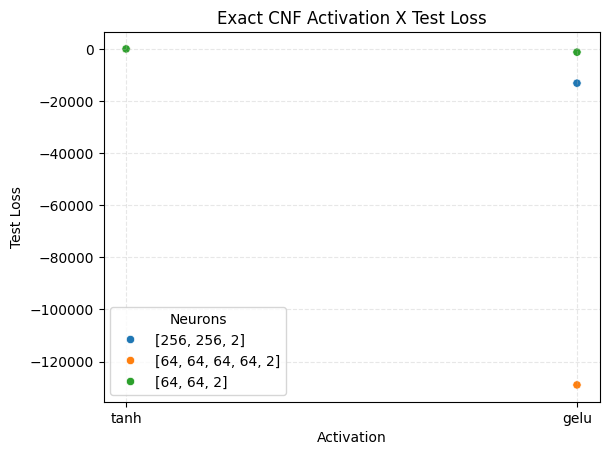

In [16]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.scatterplot(
    y='metrics.test.loss', 
    x='params.model.vector_field.activations', 
    data=exact_cnf_runs_df,
    hue='params.model.vector_field.neurons_per_layer',
    ax=ax
)
ax.set(
    xlabel='Activation',
    ylabel='Test Loss',
    title='Exact CNF Activation X Test Loss'
)
ax.legend(title='Neurons')

### Fit duration

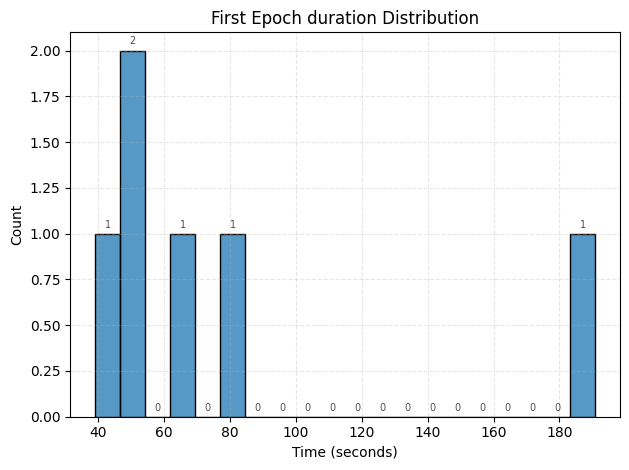

In [33]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    exact_cnf_runs_df,
    x='metrics.fit_duration',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
plt.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=3,
              fontsize='x-small', alpha=0.7) 
ax.set_title(
    'First Epoch duration Distribution',
    fontsize='large'
)
ax.set_xlabel('Time (seconds)', fontsize='medium')
fig.tight_layout()

### Min test loss

In [17]:
min_exact_cnf_idx = exact_cnf_runs_df['metrics.test.loss'].idxmin()
min_exact_cnf_run = exact_cnf_runs_df.loc[min_exact_cnf_idx]
for job in exact_cnf_jobs:
    if job.id_ == min_exact_cnf_run['run_id']:
        min_exact_cnf_job = job
        break
min_exact_cnf_job

MoonsTimeEmbeddingMLPCNFJob(id_='99f7b6afea4845bb91c6d14e9a933f48', name='exact-cnf-moons-1', model=TimeEmbeddingMLPCNFModel(id_=None, name=None, prefix='', vector_field=TimeEmbeddingMLPConfig(id_=None, name=None, prefix='', input_dims=2, time_embed_dims=16, time_embed_freq=100.0, neurons_per_layer=[64, 64, 64, 64, 2], activations=['gelu', 'gelu', 'gelu', 'gelu', 'gelu']), adjoint=True, base_distribution='standard_normal', integration_times=[0.0, 1.0], solver='dopri5', atol=0.01, rtol=0.01, learning_rate=0.001, accelerator='cpu', checkpoints_dir=None, max_epochs=1, patience=1, verbose=True, mode='min', monitor='val_loss', num_sanity_val_steps=5, profiler='simple', min_delta=1.0, input_shape=(2,)), datamodule=<even_flow.moons.dataset.MoonsDataset object at 0x7ef6597cfa70>, metrics={'train': {'loss': -128772.421875, 'nfe': 5409}, 'val': {'loss': -128446.765625, 'nfe': 528}, 'test': {'loss': -128983.0234375, 'nfe': 588}, 'predict': {}})

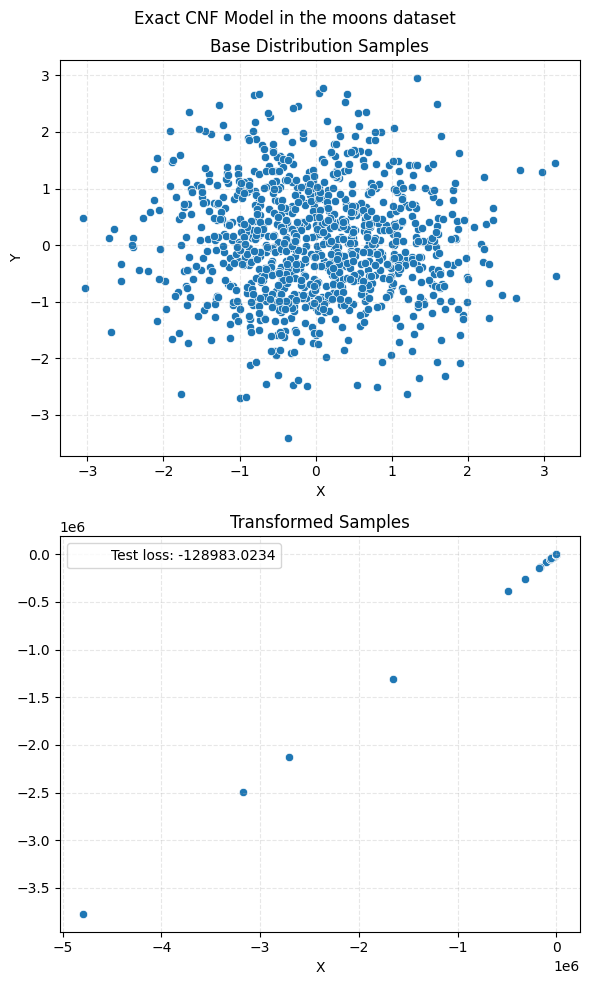

In [30]:
# sample_time_estimation = 100
# delta = []
# for _ in range(sample_time_estimation):
#     start = datetime.now(timezone.utc).timestamp()
#     n_samples = 1000
#     min_exact_cnf_job.model.sample((n_samples,))
#     finish = datetime.now(timezone.utc).timestamp()
#     delta.append(finish - start)
# delta = np.array(delta)
# avg = np.mean(delta)
# std = np.std(delta)
# logger.info(f'Average sampling time over {sample_time_estimation} runs: {avg:.5f} ± {std:.5f} seconds')

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
transformed_samples, base_samples, fig, axes = min_exact_cnf_job.plot_comparison(n_samples=n_samples, axes=axes)
fig.suptitle('Exact CNF Model in the moons dataset')
fig.tight_layout()
axes[1].plot([], [], ' ',
             label=f'Test loss: {min_exact_cnf_run["metrics.test.loss"]:.4f}',)
axes[1].legend()

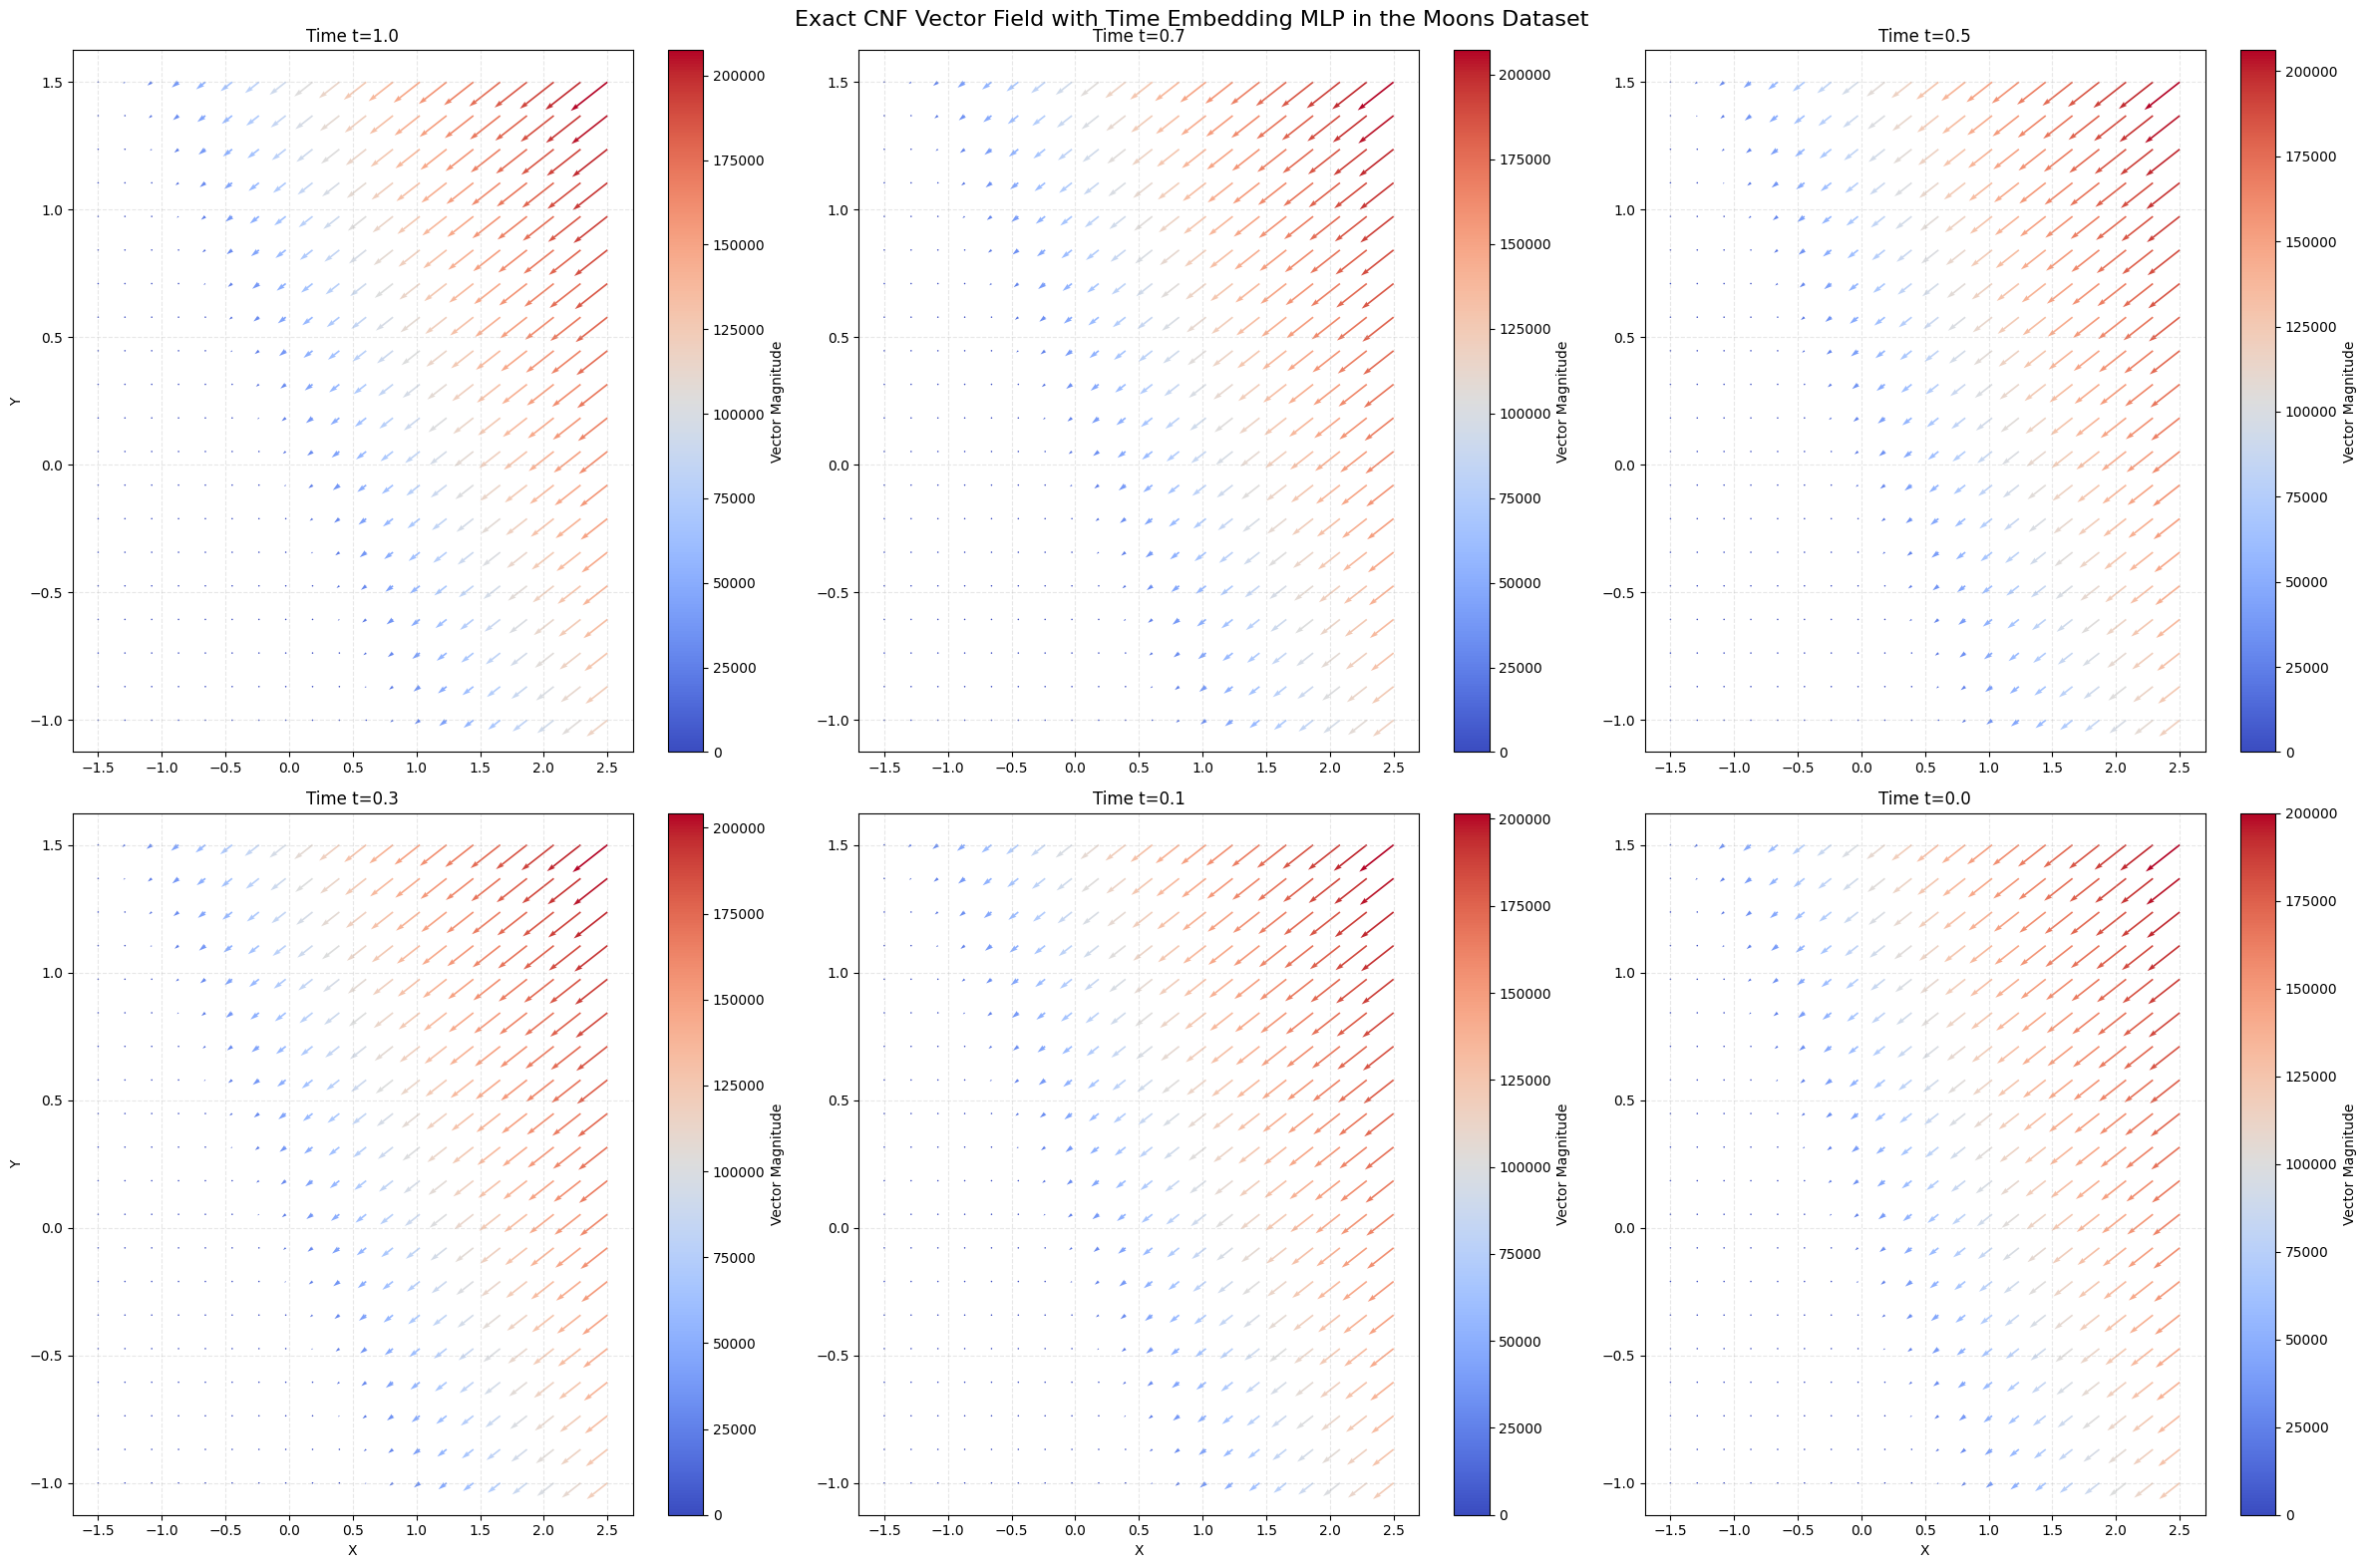

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
for ax in axes[-1, :].flatten():
    ax.set_xlabel('X')
for ax in axes[:, 0].flatten():
    ax.set_ylabel('Y')
times = [1.0, 0.7, 0.5, 0.3, 0.1, 0.0]
for t, ax in zip(times, axes.flatten()):
    ax.set_title(f'Time t={t}') 
    ax.grid(alpha=.3, linestyle='--')
    min_exact_cnf_job.vector_field_plot(
        x=torch.linspace(-1.5, 2.5, 20),
        y=torch.linspace(-1.0, 1.5, 20),
        t=t,
        ax=ax,
        cmap='coolwarm'
    )
fig.suptitle('Exact CNF Vector Field with Time Embedding MLP in the Moons Dataset', fontsize=16)
fig.tight_layout()